In [1]:
import pandas as pd
import numpy as np
import ppscore as pps
import plotly.express as px
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
import xgboost as xgb

/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# read in dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
y = train.Survived
train.shape

(891, 12)

In [3]:
# survived is dependent variable
var = train.columns
target = 'Survived'
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
774,775,1,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,NaN,S
113,114,0,3,"Jussila, Miss. Katriina",female,20.0,1,0,4136,9.8250,NaN,S
240,241,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C
866,867,1,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C
561,562,0,3,"Sivic, Mr. Husein",male,40.0,0,0,349251,7.8958,NaN,S


In [4]:
print(f"Survival rate of {round(train.Survived.sum() / train.Survived.count(),3) * 100} %")

Survival rate of 38.4 %


In [6]:
# before continuing we will create folds
# create kfold column filled with -1
train['kfold'] = -1

# next we have to randomize the rows of data
train = train.sample(frac=1).reset_index(drop = True)

# specify target variable
y = train.Survived.values

# initiate the kfold class from model_selection module
kf = model_selection.KFold(n_splits=5)

# fill the new kfold columnm
for f, (t_,v_) in enumerate(kf.split(X=train,y=y)):
    train.loc[v_,'kfold'] = f

# save the new csv with kfold column
train.to_csv('train_folds.csv',
            index = False)

In [5]:
df = pd.read_csv('train_folds.csv')

### Classify variables

- Categorical variables: Survived, Sex, Cabin, Embarked
- Ordinal variables: Pclass
- Continuous variables: Age, Fare
- Discrete variables: SibSp, Parch

In [6]:
# check to see how many values are missing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  kfold        891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


- many cabin selections are missing, ages are also missing and a few embarked values are missing
- Name, Sex, Ticket, Cabin, Embarked are all objects

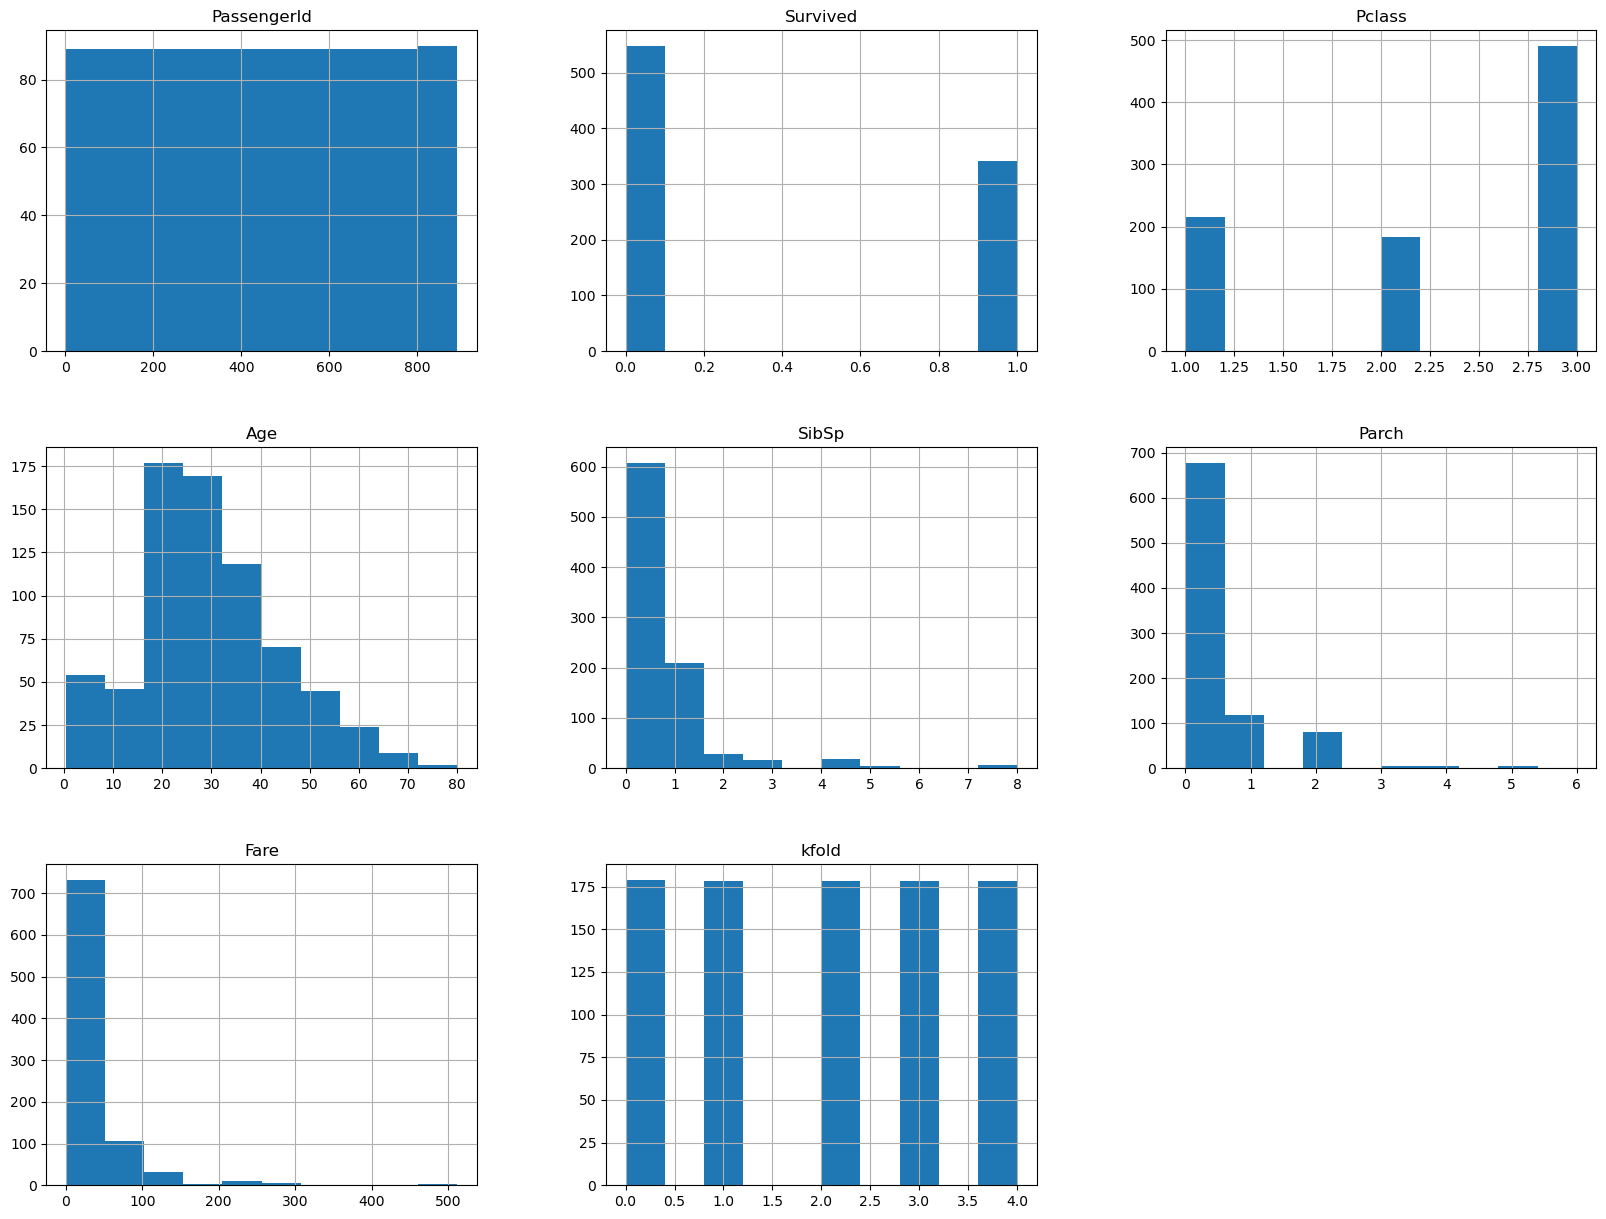

In [8]:
# let's look at a distribution of numerical values
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins = 10,
        figsize = (20,15))
plt.show()

### Observations
- more people died than survived
- most people were in third class
- most values for sibsp are zero meaning passengers travelled without a spouse or sibling though might been travelling with a fiance
- Parch values mostly zero meaning most passengers were travelling with their partner
- Fares look reasonable except for the large fare that was more than 500

In [9]:
# let's look at a correlation matrix
# now lets look for correlations
corr_matrix = df.corr()
corr_matrix['Survived'].sort_values(ascending = False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
kfold         -0.016688
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

### observations
- correlations aren't very strong
- limitation is it only checks for linear relationships
- there might be other relationships we need to investigate

/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least popu

<AxesSubplot:xlabel='x', ylabel='y'>

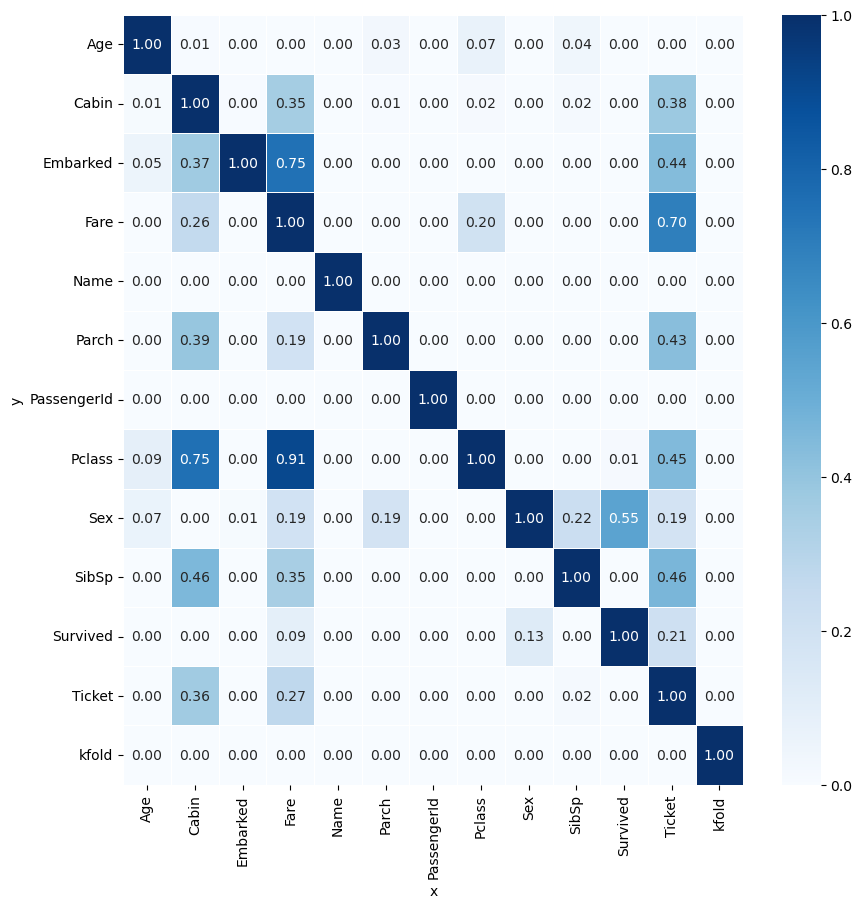

In [10]:
# explore some of the missing variables
fig, ax = plt.subplots(figsize = (10,10))
ppscores = pps.matrix(df)
ppscores = ppscores[["x", "y", "ppscore"]].pivot(columns="x", index="y", values="ppscore")
sns.heatmap(
    ppscores, 
    vmin=0, 
    vmax=1, 
    cmap="Blues", 
    linewidths=0.7, 
    annot=True,
    fmt = '.2f'
)

### Observations from PPSCORE
- cabin, fare are a strong predictor of class which intuitively makes sense
- title is a very strong predictor of sex
- ticket has strong relationships with a number of variables

In [11]:
# perform some feature engineering and fill in missing values
def feature_engineer(df):
    # we will fill cabin values with NONE
    df.Cabin = df.Cabin.fillna('NONE')
    df.Embarked = df.Embarked.fillna('NONE')
    # create a feature that splits names
    df[['Last_name','title','first_name']] = df.Name.str.split(' ', expand = True).iloc[:,0:3]
    # fill missing age values with the median age of the people with a given title
    df.groupby('title').median()
    df.Age = df.groupby('title')['Age'].apply(lambda x: x.fillna(x.median()))
    df.Age = df.Age.fillna(df.Age.median())
    df[['last','first']] = df.Name.str.split(', ', expand = True, n = 1)
    df[['title','first']] = df['first'].str.split('. ', n = 1, expand = True)
    df['Fare'] = df['Fare'].fillna(df.Fare.median())
    return df

In [12]:
# define features and create subsets for numerical and categorical
features = [
    f for f in df.columns if f not in (
        'kfold','PassengerId','Name','Last_name','first_name','last','first','Survived'
    )
]
num_cols = [
    'Pclass',
    'Age',
    'SibSp',
    'Parch',
    'Fare'
]
cat_cols = []
for i in features:
    if i not in num_cols:
        cat_cols.append(i)

In [15]:
df = feature_engineer(df)
test_df = feature_engineer(test)

In [16]:
# create full dataset with train and test to fit standardscaler and OHE
full_data = pd.concat(
        [df[features], test_df[features]],
        axis = 0
    )

In [18]:
# pipeline to scale numerical values and one hot encode categorical values
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

full_pipeline  = ColumnTransformer([
    ('num',StandardScaler(),num_cols),
    ('cat',OneHotEncoder(), cat_cols),
])

full_pipeline.fit(full_data)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat', OneHotEncoder(),
                                 ['Sex', 'Ticket', 'Cabin', 'Embarked'])])

In [19]:
x_train = full_pipeline.transform(df[features])
x_test = full_pipeline.transform(test_df[features])

### Time for Modelling
#### Logistic Regression

In [20]:
from sklearn import linear_model
model = linear_model.LogisticRegression()
model.fit(x_train, df.Survived)

LogisticRegression()

In [24]:
logres_preds = model.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,logres_preds),3)}')

AUC = 0.516


- using area under the curve as target metric
- not a great result

In [30]:
# create predictions on test set
test_preds = model.predict(x_test)
sub_logres = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Survived':test_preds
})

In [31]:
sub_logres.to_csv('logres_submission_v2.csv',
                  index = False)

#### XGB classifier

In [32]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_jobs = -1
)
model.fit(x_train,y)

[09:41:49] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
xgb_preds = model.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,xgb_preds),3)}')

AUC = 0.897


In [34]:
xgb_test_preds = model.predict(x_test)
sub_xgb = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Survived':xgb_test_preds
})

In [36]:
sub_xgb.to_csv('xgb_submission.csv',
              index = False)

#### Random forest

In [37]:
from sklearn import ensemble

model = ensemble.RandomForestClassifier(n_jobs = -1)
model.fit(x_train,y)
rf_preds = model.predict(x_train)
print(f'AUC = {round(metrics.roc_auc_score(y,rf_preds),3)}')

AUC = 0.992


In [38]:
rf_test_preds = model.predict(x_test)
sub_rf = pd.DataFrame({
    'PassengerId':test_df.PassengerId,
    'Survived':rf_test_preds
})
sub_rf.to_csv('rf_submission.csv',
              index = False)

### Conclusion
- more complex models performed better on the training set
- though they underperformed on the test set
- logistic regression performed the best with a score of 77.99%
- the score was strong enough for a top quartile placing